# CMS Three Top Analysis: `ABCDnn` Data-Driven Background Estimation
Using neural affine flow (arXiv:1804.00779) to learn a transformation from MC background to data.  
## Introduction
`ABCDnn` is a DNN-based method for ABCD-type extrapolation. This method allows multi-dimensional distributions to be predicted, in particular, for the signal region (SR) distribution to be predicted from control regions (CR) using a DNN. In the search for $pp\rightarrow{t\bar{t}t}$, the regions are categorized in a 2D phase space of the jet multiplicity ($N_j$) and $b$-jet multiplicity ($N_b$). In comparison to the original `ABCD` method, a total of 5 CRs are used rather than 3 to exploit more information.  

The `ABCDnn` method is used to predict the SR distribution of background events in data by learning an invertible bijective function using the 5 simulation CRs. The transformation between the distributions of feature variables are constructed as an invertible bijective function through Neural Autoregressive Flow (NAF). The training is optimized by minimizing the maximum-mean-discrepancy (MMD) between the distributions of source and target. After training the NAF, the transformation between source and target under the SR condition is applied to the simulated events in the SR, which then should resemble the shape of the background in the SR.   

__Note: ABCDnn cannot be used for yield prediction since the number of source events is preserved in an invertible transformation__

## Set-up Google Colab and Import Relevant Libraries

In [1]:
#@title Mount Google Drive
from google.colab import drive
drive.mount( "/content/drive", force_remount = False )

%cd /content/drive/My Drive/Physics Research/CMS/Analysis/TTT 1lep/TTT ABCDnn/

Mounted at /content/drive
/content/drive/My Drive/Physics Research/CMS/Analysis/TTT 1lep/TTT ABCDnn


In [2]:
#@title Install `pythonic` libraries
%%capture
!pip install uproot==3.12.0
!pip install scikit-hep==1.2.1
!pip install scikit-optimize

In [3]:
#@title Import `pythonic` libraries
#@markdown This notebook was developed for `tensorflow 2.7.0`
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_probability as tfp
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from skhep.visual import MplPlotter
import uproot
import ipywidgets as widget
from scipy import stats
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import shuffle as shuffle_data

## Define Variable Parameters, Methods and Classes

In [4]:
#@markdown Select a source file
wSource = widget.Dropdown( options = [ file for file in next( os.walk( os.getcwd() + "/Data/" ) )[2] if "mc" in file ] )
wSource

Dropdown(options=('source_ttbar_mc.root', 'source_qcd_mc.root', 'Semileptonic_inc_2017_mc.root', 'ttbar_2017_m…

In [5]:
#@markdown Select a target file
wTarget = widget.Dropdown( options = [ file for file in next( os.walk( os.getcwd() + "/Data/" ) )[2] if "data" in file ] )
wTarget

Dropdown(options=('target_data.root', 'singleLep_2017_data.root', 'singleLep_UL17_data.root', 'singleLep_16_da…

In [6]:
#@title Use randomized seed?
use_randSeed = widget.Dropdown( options = [ True, False ], value = False )
use_randSeed

Dropdown(index=1, options=(True, False), value=False)

## ABCDnn Parameters
* __`inputdim`__ is the number of input variables - number of control variables
* __`NDense`__ (default = `128`) is the number of nodes in the transformer hidden layers
* __`inputdim_categorical_list`__
* __`minibatch`__ (default = `64`) is the size of the minibatch
* __`nafdim`__ is the number of nodes in conditioner hidden layers
* __`depth`__ is the chain length of the flow
* __`lr`__ is the starting learning rate for the Adam optimizer
* __`gap`__ is the period of the learning rate scheduler
* __`conddim`__ is the input dimension of the conditioner network (= # transformed variables + 5)
* __`beta1`__ (default = `0.9`) is the exponential decay rate for the Adam optimization 1st moment estimates
* __`beta2`__ (default = `0.999`) is the exponential decay rate for the Adam optimization 2nd moment estimates
* __`retrain`__ is a `bool` for overriding a previous training instance
* __`permute`__ is a `bool` for using random permutations on the input orders for each chain in the flow
* __`monitorevery`__ is an `int` for the number of epochs between reporting the training performance

In [8]:
#@title Set Parameter Values __(check me)__

data_path = "./Data/"

variables = {
  "AK4HT": {
    "categorical": False,           # True if integer values
    "transform": True,              # True if desired distribution
    "limit": [0.,3000.],            # min, max values
    "latex": "H_T\ \mathrm{(GeV)}" # plotting string
  },
  "BDT": {
    "categorical": False,
    "transform": True,
    "limit": [0.,1.],
    "latex": "BDT_{4T}"
  },
  "NJets_JetSubCalc": { # control variable
    "categorical": True,
    "transform": False,
    "limit": [0,20],
    "latex": "N_j"
  },
  "NJetsCSV_MultiLepCalc": { # control variable
    "categorical": True,
    "transform": False,
    "limit": [0,10],
    "latex": "N_b"
  }
}

nTrans = len( [ variable for variable in variables if variables[ variable ][ "transform" ] == True ] )

selection = {
  "AK4HT": 500.,
  "NJets_JetSubCalc": 4
}

# Inclusive implies highest bin is >= rather than ==
regions = {
  "X": { # the X variable should have a range of 3
    "Variable": "NJets_JetSubCalc",
    "Inclusive": True,
    "Min": 5,
    "Max": 7,
    "Signal": 7
  },
  "Y": { # the Y variable should have a range of 2
    "Variable": "NJetsCSV_MultiLepCalc",
    "Inclusive": True,
    "Min": 2,
    "Max": 3,
    "Signal": 3
  }
}

if int( regions[ "X" ][ "Max" ] - regions[ "X" ][ "Min" ] + 1 ) * int( regions[ "Y" ][ "Max" ] - regions[ "Y" ][ "Min" ] + 1 ) != 6:
  print( "[WARN] The chosen control variable regions is not 6. Please choose new parameters.")

params = {
  "EVENTS": { # parameters for preparing the events
    "SOURCE": data_path + wSource.value,
    "TARGET": data_path + wTarget.value,
    "MCWEIGHT": None   
  },
  "MODEL": { # parameters for setting up the NAF model
    "NODES_COND": 16,
    "HIDDEN_COND": 3,
    "NODES_TRANS": 8,
    "LRATE": 1e-5,
    "DECAY": 1e-1,
    "GAP": 500.,
    "DEPTH": 3,
    "REGULARIZER": "None", # L2
    "ACTIVATION": "softplus",
    "BETA1": 0.99,
    "BETA2": 0.999,
    "MINIBATCH": 2**7,
    "RETRAIN": True,
    "SEED": 101 if use_randSeed.value else np.random.randint( 100000 ),
    "SAVEDIR": "./Results/",
    "VERBOSE": False   
  },
  "TRAIN": { # parameters for training the NAF Model
    "EPOCHS": 20000,
    "PATIENCE": 5000,
    "MONITOR": 1000,
    "SPLIT": 0.25,
    "SHOWLOSS": True,
    "SAVEHP": True
  }
}

hyper = {
  "OPTIMIZE": {
    "NODES_COND": ( [4,8,16,32,64], "CAT" ), # number of nodes in the conditional network hidden layer
    "HIDDEN_COND": ( [1,5], "INT" ), # number of hidden layers in the conditional network
    "NODES_TRANS": ( [1,2,4,8,16], "CAT" ), # number of nodes in the network transforming hidden layer
    "LRATE": ( [1e-5,1e-4,1e-3], "CAT" ), # starting learning rate for the optimizer
    "DECAY": ( [1,1e-1,1e-2,1e-3], "CAT" ), # final learning rate multiplier
    "GAP": ( [500,1000,5000], "CAT" ), # learning rate scheduler gap
    "DEPTH": ( [1,4], "INT" ), # permutation depths
    "REGULARIZER": ( ["L1","L2","L1+L2","None"], "CAT" ), # training regularization
    "ACTIVATION": ( [ "swish", "relu", "elu", "softplus" ], "CAT" ), # non-linear transformation activation function
    "BETA1": ( [0.90,0.99,0.999], "CAT" ), # Beta1 for Adam optimizer
    "BETA2": ( [0.90,0.99,0.999], "CAT" ), # Beta2 for Adam optimizer
  },
  "PARAMS": {
    "PATIENCE": 10000,
    "EPOCHS": 10000,
    "N_RANDOM": 5,
    "N_CALLS": 20,
    "MINIBATCH": 2**7,
    "VERBOSE": True
  }
}

space = []
for hp in hyper[ "OPTIMIZE" ]:
  if hyper[ "OPTIMIZE" ][ hp ][1] == "CAT":
    space.append( Categorical( hyper[ "OPTIMIZE" ][ hp ][0], name = str( hp ) ) )
  elif hyper[ "OPTIMIZE" ][ hp ][1] == "INT":
    space.append( Integer( hyper[ "OPTIMIZE" ][ hp ][0][0], hyper[ "OPTIMIZE" ][ hp ][0][1], name = str( hp ) ) )
  elif hyper[ "OPTIMIZE" ][ hp ][1] == "REAL":
    space.append( Real( hyper[ "OPTIMIZE" ][ hp ][0][0], hyper[ "OPTIMIZE" ][ hp ][0][1], name = str( hp ) ) )


In [9]:
#@title Construct Neural Autoregressive Flow (NAF) Methods
#@markdown * `invsigmoid( x )`: return inverse sigmoid function 
#@markdown * `NAF( inputdim, ndense, conddim, nafdim, depth, permute )`: return NAF Model

# inverse sigmoid
def invsigmoid( x ):
  xclip = tf.clip_by_value( x, 1e-6, 1.0 - 1e-6 ) # constrains x to the specified min and max
  return tf.math.log( xclip / ( 1.0 - xclip ) )

# construct NAF model
def NAF( inputdim, conddim, activation = "swish", regularizer = "None", nodes_cond = 8, hidden_cond = 1, nodes_trans = 8, depth = 1, permute = True ):
  activation_key = {
    "swish": tf.nn.swish,
    "softplus": tf.nn.softplus,
    "relu": tf.nn.relu,
    "elu": tf.nn.elu
  }
  regularizer_key = {
    "L1": tf.keras.regularizers.L1,
    "L2": tf.keras.regularizers.L2,
    "L1+L2": tf.keras.regularizers.L1L2,
    "None": None
  }
  
  xin = layers.Input( shape = ( inputdim + conddim, ), name = "Input_Layer" )
  xcondin = xin[ :, inputdim: ]     # shape=(None, conddim)
  xfeatures = xin[ :, :inputdim ]   # shape=(None,inputdim)
  nextfeature = xfeatures

  for idepth in range(depth):
    if permute:
      randperm = np.random.permutation( inputdim ).astype( "int32" )
      permutation = tf.constant( randperm )
    else:
      permutation = tf.range( inputdim, dtype = "int32", name = f"permutation{idepth}" )
    permuter = tfp.bijectors.Permute( permutation = permutation, name = f"permute{idepth}" ) # permutes rightmost dimension of tensor
    xfeatures_permuted = permuter.forward( nextfeature ) # returns forward Bijector evaluation i.e. X = g(Y)
    outlist = []
    for iv in range( inputdim ):
      xiv = tf.reshape( xfeatures_permuted[ :, iv ], [ -1, 1 ] )
      net1 = xiv
      condnet = xcondin
      for i in range( hidden_cond ):
        condnet = layers.Dense( nodes_cond, activation = activation_key[ activation ], kernel_regularizer = regularizer_key[ regularizer ], name = f"Cond_Dense_{idepth}_{iv}_{i}" )( condnet )
      w1 = layers.Dense( nodes_trans, activation = tf.nn.softplus, name = f"Sigmoid_Weight_{idepth}_{iv}" )( condnet ) # has to be softplus to be >0
      b1 = layers.Dense( nodes_trans, activation = None, name = f"Sigmoid_Bias_{idepth}_{iv}" )( condnet )
      net2 = tf.nn.sigmoid( w1 * net1 + b1, name = f"Trans_Dense_{idepth}_{iv}" ) # invertible one dimensional function of x

      condnet = xcondin
      for i in range( hidden_cond ):
        condnet = layers.Dense( nodes_cond, activation = activation_key[ activation ], kernel_regularizer = regularizer_key[ regularizer ], name = f"Inv_Cond_Dense_{idepth}_{iv}_{i}" )( condnet )
      w2 = layers.Dense( nodes_trans, activation = tf.nn.softplus, name = f"Inv_Sigmoid_Weight_{idepth}_{iv}" )( condnet )
      w2 = w2 / ( 1.0e-3 + tf.reduce_sum( w2, axis=1, keepdims = True ) ) # normalize

      net3 = invsigmoid( tf.reduce_sum( net2 * w2, axis = 1, keepdims = True ) )
      outlist.append( net3 )
      xcondin = tf.concat( [ xcondin, xiv ], axis = 1 )

    outputlayer_permuted = tf.concat( outlist, axis = 1 )
    outputlayer = permuter.inverse( outputlayer_permuted )
    nextfeature = outputlayer

  return keras.Model( xin, outputlayer )

In [10]:
#@title Maximum Mean Discrepancy Loss Methods
#@markdown * `mix_rbf_kernel()`: is used within mix_rbf_mmd2
#@markdown * `mix_rbf_mmd2()`

def mix_rbf_kernel( X, Y, sigmas, wts = None ):
  if wts is None:
    wts = [1] * len( sigmas )
  
  # matmul is matrix multiplication between X and Y
  # X is the target batch, Y is the generated batch
  XX = tf.matmul( X, X, transpose_b = True )
  XY = tf.matmul( X, Y, transpose_b = True )
  YY = tf.matmul( Y, Y, transpose_b = True )

  X_sqnorms = tf.linalg.diag_part( XX )
  Y_sqnorms = tf.linalg.diag_part( YY )

  r = lambda x: tf.expand_dims( x, 0 )
  c = lambda x: tf.expand_dims( x, 1 )

  K_XX, K_XY, K_YY = 0, 0, 0

  for sigma, wt in zip( sigmas, wts ):
    gamma = 1 / ( 2 * sigma**2 )
    K_XX += wt * tf.exp( -gamma * ( -2 * XX + c(X_sqnorms) + r(X_sqnorms) ) )
    K_XY += wt * tf.exp( -gamma * ( -2 * XY + c(X_sqnorms) + r(Y_sqnorms) ) )
    K_YY += wt * tf.exp( -gamma * ( -2 * YY + c(Y_sqnorms) + r(Y_sqnorms) ) )

  # reduce_sum() computes sum of elements across dimensions of a tensor
  return K_XX, K_XY, K_YY, tf.reduce_sum( wts )

def mix_rbf_mmd2( X, Y, sigmas = ( 1, ), wts = None ):
  K_XX, K_XY, K_YY, d = mix_rbf_kernel( X, Y, sigmas, wts )
  m = tf.cast( tf.shape( K_XX )[0], tf.float32 )
  n = tf.cast( tf.shape( K_YY )[0], tf.float32 )

  mmd2 = (tf.reduce_sum(K_XX) / (m * m) + tf.reduce_sum(K_YY) / (n * n) - 2 * tf.reduce_sum(K_XY) / (m * n))
  return mmd2

## Maximum Mean Discrepancy (MMD) Loss 
MMD is defined by the idea of representing distances between distributions as distances between _mean embeddings_ of features. For two distributions $D_1$ and $D_2$ over a set $\mathcal{X}$, the MMD is defined by the _feature map_ $\phi:\mathcal{X}\rightarrow{\mathcal{H}}$, where $\mathcal{H}$ is a _reproducing kernel_ Hilbert space. 

The MMD is generally defined as,  

$$
\mathrm{MMD}(D_1,D_2)=||\mathbb{E}_{X\sim D_1}[\phi(X)]-\mathbb{E}_{Y\sim D_2}[\phi(Y)]||_\mathcal{H}
$$

In the case that $\phi$ maps to a general reproducing kernel Hilbert space, such as with the NAF, then the MMD can be computed using the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method) where the two transfer maps can be represented by,

$$
k(x,y)=\langle\phi(x)|\phi(x)\rangle_\mathcal{H}
$$

and the squared-MMD can be evaluated as,  

$$
\mathrm{MMD}^2(D_1,D_2)=\mathbb{E}_{X,X'\sim D_1}k(X,X')+\mathbb{E}_{Y,Y'\sim D_2}k(Y,Y')-2\mathbb{E}_{X\sim D_1,Y\sim D_2}k(X,Y)
$$

Kernel functions are used to transform an $n$-dimensional input to $m$-dimensional input, where $m>>n$. To achieve this, a linear classifier in higher dimensions becomes a non-linear classifier in lower dimensions. The kernels are computed from the resulting generated and target distributions according to a weighted exponential function.  The kernels are also normalized according to the shape of the generated and target distributions.  

The kernel used for ABCDnn is the [Radial Basis Function (RBF) kernel](https://www.geeksforgeeks.org/radial-basis-function-kernel-machine-learning/) (see here for a [technical description](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)\), which is commonly used in Support Vector Machine Classification. The RBF kernel is defined for two samples of $\mathrm{x_1}$ and $\mathrm{x_2}$ as,  

$$
k(x_1,x_2)=\left( -\frac{||\mathrm{x_1}-\mathrm{x_2}||^2}{2\sigma ^2} \right)
$$

where $\sigma$ is a free parameter. The RBF kernel is best understood for its property where the kernel output is strongest at the center (i.e. $x_1-x_2=0$) and is used in problems with complex distributions.

In [11]:
#@title Onehot Encoding Class
#@markdown `class OneHotEncoder_int()`:
#@markdown * `def applylimit()`
#@markdown * `def _encode()`
#@markdown * `def encode()`: encode the input MC and data in `prepdata()`
#@markdown * `def encodedcategories()`: return number of encoded categories
#@markdown * `def transform()`: encode the inputdata
#@markdown * `def _decode()`: decode the one-hot encoded data
#@markdown * `def decode()`: 

# custom one-hot encoder for integer inputs with overflows
class OneHotEncoder_int( object ):
  def __init__( self, categorical_features, lowerlimit = None, upperlimit = None ):
    self.iscategorical = categorical_features
    self.ncolumns = len(categorical_features)
    self.ncats = 0
    self.categories_per_feature = []

    self.ncatgroups = 0
    for b in categorical_features:
      if b:
        self.ncatgroups += 1
    self.lowerlimit = lowerlimit 
    self.upperlimit = upperlimit
    self.categories_fixed = False
    pass

  def applylimit( self, categoricalinputdata ):
    if self.lowerlimit is None:
      self.lowerlimit = np.min( categoricalinputdata, axis=0 )
    else:
      self.lowerlimit = np.maximum( self.lowerlimit, np.min( categoricalinputdata, axis = 0 ) )
    
    if self.upperlimit is None:
      self.upperlimit = np.max( categoricalinputdata, axis = 0 )
    else:
      self.upperlimit = np.minimum( self.upperlimit, np.max( categoricalinputdata, axis = 0 ) )

    lowerlimitapp = np.maximum( categoricalinputdata, self.lowerlimit )
    limitapp = np.minimum( lowerlimitapp, self.upperlimit )
    
    return limitapp

  def _encode( self, inputdata ):
  # this one is not currently being used
    categorical_columns = inputdata[ :, self.iscategorical ]
    float_columns = inputdata[ :, [ not i for i in self.iscategorical ] ]

    cat_limited = self.applylimit( categorical_columns ) - self.lowerlimit.astype( int )

    catshape = categorical_columns.shape

    arraylist = []
    if not self.categories_fixed:
      for cat in range( catshape[1] ):
        ncats = int( self.upperlimit[cat] - self.lowerlimit[cat] + 1 ) # number of categories
        self.categories_per_feature.append( ncats )
        self.ncats += ncats 
      self.categories_fixed = True

    for cat in range( catshape[1] ):
      ncats = int( self.upperlimit[cat] - self.lowerlimit[cat] + 1 )
      res = np.eye( ncats )[ cat_limited[:,cat] ]
      arraylist.append( res )
    if float_columns.shape[1] > 0:
      arraylist.append( float_columns )
    encoded = np.concatenate( tuple( arraylist ), axis = 1 ).astype( np.float32 )
    return encoded

  def encode( self, inputdata ):
  # encoding done in prepdata()
    cat_limited = self.applylimit( inputdata ) - self.lowerlimit

    # one hot encoding information
    if not self.categories_fixed:
      for icol, iscat in zip( range( self.ncolumns ), self.iscategorical ):
        if iscat:
          ncats = int( self.upperlimit[icol] - self.lowerlimit[icol] + 1 )
          self.categories_per_feature.append( ncats )
          self.ncats += ncats 
        else:
          self.categories_per_feature.append( 0 )
      self.categories_fixed = True

    # the encoding part
    arraylist = []
    for icol, ncat_feat in zip( range( self.ncolumns ), self.categories_per_feature ):
      if ncat_feat > 0:
        res = np.eye( ncat_feat )[ cat_limited[ :,icol ].astype(int) ]
        arraylist.append( res )
      else:
        arraylist.append( inputdata[:,icol].reshape( ( inputdata.shape[0], 1 ) ) )
    encoded = np.concatenate( tuple( arraylist ), axis = 1 ).astype( np.float32 )
    return encoded

  def encodedcategories( self ):
    return self.ncats

  def transform( self, inputdata ):
    return self.encode( inputdata )

  def _decode( self, onehotdata ):
    colstart = 0

    arraylist = []
    for i in range( self.ncatgroups ):
      ncats = int( self.upperlimit[1] - self.lowerlimit[i] + 1 ) # number of categories
      datatoconvert = onehotdata[ :, colstart:colstart+ncats ]
      converted = np.argmax( datatoconvert, axis = 1 ) + self.lowerlimit[i] 
      converted = np.reshape( converted, newshape = ( converted.shape[0], 1 ) )
      arraylist.append( converted )
      colstart += ncats
    if colstart < onehotdata.shape[1]:
      arraylist.append( onehotdata[ :, colstart: ] )
    decoded = np.concatenate( tuple( arraylist ), axis = 1 )
    return decoded

  def decode( self, onehotdata ):
    current_col = 0 # start from column 0
    arraylist = []
    for ifeat, ncats in zip( range( len( self.categories_per_feature ) ), self.categories_per_feature ):
      if ncats > 0:
        datatoconvert = onehotdata[ :, current_col:current_col+ncats ]
        converted = np.argmax( datatoconvert, axis = 1 ) + self.lowerlimit[ ifeat ]
        converted = np.reshape( converted, newshape = ( converted.shape[0], 1 ) )
        arraylist.append( converted )
        current_col += ncatgroups
      else:
        arraylist.append( onehotdata[:, current_col].reshape((onehotdata.shape[0], 1) ) )
        current_col += 1
    decoded = np.concatenate( tuple( arraylist ), axis = 1 )
    return decoded


In [12]:
#@title Learning Rate Scheduling Class 
#@markdown `class SawtoothSchedule()`: learning rate scheduler
#@markdown * `__call()__`: return the learning rate
#@markdown * `get_config()`: return the learning rate scheduler parameters

class SawtoothSchedule(LearningRateSchedule):
  def __init__(self, start_learning_rate = 1e-4, end_learning_rate = 1e-6, cycle_steps = 100, random_fluctuation = 0.0, name = None ):
    super( SawtoothSchedule, self ).__init__()
    self.start_learning_rate = start_learning_rate 
    self.end_learning_rate = end_learning_rate
    self.cycle_steps = cycle_steps
    self.random_fluctuation = random_fluctuation
    self.name = name
  pass

  def __call__( self, step ):
    phase = step % self.cycle_steps
    lr = self.start_learning_rate + ( self.end_learning_rate - self.start_learning_rate ) * ( phase / self.cycle_steps )
    if ( self.random_fluctuation > 0 ):
      lr *= np.random.normal( 1.0, self.random_fluctuation )
    return lr

  def get_config( self ):
    return {
        "start_learning_rate": self.start_learning_rate,
        "end_learning_rate": self.end_learning_rate,
        "cycle_step": self.cycle_steps,
        "random_fluctuation": self.random_fluctuation,
        "name": self.name
    }


In [13]:
#@title `ABCDnn` Class (WIP)
#@markdown `class ABCDnn()`:
#@markdown * `def __init__()`
#@markdown * `def createmodel()`: create the NAF model
#@markdown * `def setup()`: Set the seed, create the NAF model and check for model checkpoint
#@markdown * `def category_sorted( numpydata, verbose )`:
#@markdown * `def setrealdata( numpydata )`:
#@markdown * `def setmcdata( numpydata, eventweight )`:
#@markdown * `def savehyperparameters()`:
#@markdown * `def monitor()`:
#@markdown * `save_training_monitor()`:
#@markdown * `load_training_monitor()`:
#@markdown * `find_condmatch()`:
#@markdown * `get_next_batch( size, cond )`:
#@markdown * `train_step( sourcebatch, targetbatch, sourceweight )`:
#@markdown * `train( steps )`:
#@markdown * `display_training()`:

class ABCDnn(object):
  def __init__( self, inputdim_categorical_list, inputdim, nodes_cond, hidden_cond,
               nodes_trans, minibatch, activation, regularizer,
               depth, lr, gap, conddim, beta1, beta2, decay,
               retrain, savedir, savefile, 
               seed, permute, verbose ):
    self.inputdim_categorical_list = inputdim_categorical_list
    self.inputdim = inputdim
    self.inputdimcat = int( np.sum( inputdim_categorical_list ) )
    self.inputdimreal = inputdim - self.inputdimcat
    self.minibatch = minibatch
    self.nodes_cond = nodes_cond
    self.hidden_cond = hidden_cond
    self.nodes_trans = nodes_trans
    self.activation = activation
    self.regularizer = regularizer
    self.depth = depth
    self.lr = lr 
    self.decay = decay
    self.gap = gap
    self.conddim = conddim
    self.beta1 = beta1
    self.beta2 = beta2
    self.retrain = retrain
    self.savedir = savedir
    self.savefile = savefile
    self.global_step = tf.Variable( 0, name = "global_step" )
    self.monitor_record = []
    self.seed = seed 
    self.permute = permute
    self.verbose = verbose
    self.minloss = 0
    self.setup()

  def setup( self ):
    np.random.seed( self.seed )
    tf.random.set_seed( self.seed )
    self.createmodel()
    self.checkpoint = tf.train.Checkpoint( global_step = self.global_step, model = self.model, optimizer = self.optimizer )
    self.checkpointmgr = tf.train.CheckpointManager( self.checkpoint, directory = self.savedir, max_to_keep = 1 )
    if (not self.retrain) and os.path.exists(self.savedir):
      status = self.checkpoint.restore(self.checkpointmgr.latest_checkpoint)
      status.assert_existing_objects_matched()
      print('loaded model from checkpoint')
      if os.path.exists(os.path.join(self.savedir, self.savefile)):
        print("Reading monitor file")
        self.load_training_monitor()
      print("Resuming from step", self.global_step)
    elif not os.path.exists(self.savedir):
      os.mkdir(self.savedir)
    pass

  def createmodel( self ):
    self.model = NAF( 
      inputdim = self.inputdim,  
      conddim = self.conddim, 
      activation = self.activation,
      regularizer = self.regularizer,
      nodes_cond = self.nodes_cond, 
      hidden_cond = self.hidden_cond,
      nodes_trans = self.nodes_trans, 
      depth = self.depth, 
      permute = self.permute
    )
    if self.verbose: self.model.summary()
    self.optimizer = keras.optimizers.Adam(
      learning_rate = SawtoothSchedule( self.lr, self.lr * self.decay, self.gap, 0 ),  
      beta_1 = self.beta1, beta_2 = self.beta2, 
      epsilon = 1e-5, 
      name = 'nafopt'
    )
    pass

  def category_sorted(self, numpydata, verbose ):
    categoricals, categorical_cats, unique_counts = np.unique( numpydata[:, self.inputdimreal:], axis=0, return_inverse = True, return_counts = True)
    if verbose: 
      print(f'Data has {categoricals} unique  categorical features. The counts in categories are')
      print(unique_counts)

    # store indices separately for easy access later
    categorical_indices_grouped=[]
    for icat in range(len(categoricals)):
      cat_indices = np.where(categorical_cats == icat)[0]
      categorical_indices_grouped.append(cat_indices)
    
    return categoricals, categorical_indices_grouped

  def setrealdata( self, numpydata, verbose ):
    self.numpydata = numpydata
    self.ntotalevents = numpydata.shape[0]
    self.datacounter = 0
    self.randorder = np.random.permutation( self.numpydata.shape[0] )
    # following is dummy
    self.dataeventweight = np.ones((self.ntotalevents, 1), np.float32)
    # find unique occurrenes of categorical features in data
    self.categoricals_data, self.categorical_data_indices_grouped = self.category_sorted( self.numpydata, verbose )
    pass

  def setmcdata(self, numpydata, verbose, eventweight = None ):
    self.mcnumpydata = numpydata
    self.mcntotalevents = numpydata.shape[0]
    self.mcdatacounter = 0
    self.mcrandorder = np.random.permutation( self.mcnumpydata.shape[0] )
    if eventweight is not None:
      self.mceventweight = eventweight
    else:
      self.mceventweight = np.ones( ( self.mcntotalevents, 1) , np.float32 )
    self.categoricals_mc, self.categorical_mc_indices_grouped = self.category_sorted( self.mcnumpydata, verbose )
    pass

  def savehyperparameters(self):
    """Write hyper parameters into file
    """
    params = {
      "inputdim": self.inputdim, 
      "conddim": self.conddim, 
      "lr": self.lr,
      "decay": self.decay, 
      "gap": self.gap, 
      "nodes_cond": self.nodes_cond, 
      "hidden_cond": self.hidden_cond, 
      "nodes_trans": self.nodes_trans, 
      "beta1": self.beta1, 
      "beta2": self.beta2, 
      "minibatch": self.minibatch,
      "activation": self.activation,
      "regularizer": self.regularizer,
      "depth": self.depth  
    }
    pickle.dump( params, open( os.path.join( self.savedir, 'hyperparams.pkl' ), 'wb' ) )

  def monitor( self, step, glossv_trn, glossv_val, mmdloss_trn, mmdloss_val  ):
    self.monitor_record.append( [ 
      step, 
      glossv_trn, glossv_val, 
      mmdloss_trn, mmdloss_val 
      ]
    )

  def save_training_monitor(self):
    pickle.dump( self.monitor_record, open(os.path.join( self.savedir, self.savefile ), 'wb' ))
    pass

  def load_training_monitor(self):
    fullfile = os.path.join( self.savedir, self.savefile )
    if os.path.exists(fullfile):
      self.monitor_record = pickle.load(open(fullfile, 'rb'))
      self.epoch = self.monitor_record[-1][0] + 1
    pass

  def find_condmatch(self, size, conditional):
    
    """[Find data and MC batches matching conditional category]

    Args:
        conditional ([numpy]): [single conditional]
    """
    idx_cond = ( ( self.categoricals_data == conditional ).all( axis = 1 ).nonzero()[0])[0]
    # Data
    data_for_cond = self.categorical_data_indices_grouped[idx_cond]
    nextdatabatchidx = np.random.permutation(data_for_cond)[0:size]
    target_b = self.numpydata[nextdatabatchidx]

    # MC
    idx_cond = ((self.categoricals_mc == conditional).all(axis=1).nonzero()[0])[0]
    mc_for_cond = self.categorical_mc_indices_grouped[idx_cond]
    mcnextbatchidx = np.random.permutation(mc_for_cond)[0:size]
    source_b = self.mcnumpydata[mcnextbatchidx]

    weight_b = self.mceventweight[mcnextbatchidx]
    return target_b, source_b, weight_b
  
  def get_next_batch( self, split, size=None ):
    """Return minibatch from random ordered numpy data
    """
    if size is None:
      size = int( self.minibatch * ( ( 1. - split ) ** -1 ) )

    # reset counter if no more entries left for current batch
    if self.datacounter + size >= self.ntotalevents:
      self.datacounter = 0
      self.randorder = np.random.permutation( self.numpydata.shape[0] )

    if self.mcdatacounter + size >= self.mcntotalevents:
      self.mcdatacounter = 0
      self.mcrandorder = np.random.permutation( self.mcnumpydata.shape[0] )

    batchbegin = self.datacounter # assuming there is less data than mc events
    nextconditional = self.numpydata[ self.randorder[batchbegin], self.inputdim: ]
    target_b, source_b, weight_b = self.find_condmatch( size, nextconditional )

    while len( target_b ) != len( source_b ):
      self.datacounter += size
      self.mcdatacounter += size
      if self.datacounter >= self.ntotalevents: 
        self.datacounter = self.datacounter - self.ntotalevents
        self.randorder = np.random.permutation( self.numpydata.shape[0] )
      batchbegin = self.datacounter
      nextconditional = self.numpydata[ self.randorder[batchbegin], self.inputdim: ]
      target_b, source_b, weight_b = self.find_condmatch( size, nextconditional )

    self.datacounter += size
    self.mcdatacounter += size
    self.this_source = source_b # returning source_b converts it into a tensor rather than np array
    self.this_target = target_b
    self.this_weight = weight_b

    return source_b, target_b, weight_b

  # eqvuialent to train_step = tf.function( train_step )
  @tf.function
  def train_step(self, source, target, split, sourceweight=1. ):
    source_trn, source_val, target_trn, target_val = train_test_split(
      self.this_source, self.this_target, test_size = split
    )
    
    with tf.GradientTape() as gtape:
      # get the predicted values from the current trained model
      generated_trn = tf.concat( [
          self.model( source_trn, training = True ),
          target_trn[:, -self.conddim:]
        ],
        axis = -1
      )

      #mmdloss = mix_rbf_mmd2(targetbatch[:, :self.inputdim], generated[:, :self.inputdim], sigmas=(0.1, 0.2,)) # for 1-D or 2-D
      mmdloss_trn = mix_rbf_mmd2( target_trn[:, :self.inputdim], generated_trn[:, :self.inputdim], sigmas=(0.2, 0.5, 1.0, 2.0, 4.0) ) # not clear how these sigma values were chosen
    
    gradient = gtape.gradient( mmdloss_trn, self.model.trainable_variables )
    self.optimizer.apply_gradients( zip( 
        gradient, 
        self.model.trainable_variables 
      ) 
    )

    generated_val = tf.concat( [
        self.model( source_val, training = False ),
        target_val[ :, -self.conddim:]
      ],
      axis = -1
    )

    mmdloss_val = mix_rbf_mmd2( target_val[:, :self.inputdim], generated_val[:, :self.inputdim], sigmas=(0.2, 0.5, 1.0, 2.0, 4.0) )

    glossv_trn = tf.reduce_mean( mmdloss_trn )
    glossv_val = tf.reduce_mean( mmdloss_val )

    return glossv_trn, glossv_val, mmdloss_trn, mmdloss_val

  def train( self, steps = 10000, monitor = 1000, patience = 100, early_stopping = True, split = 0.25, hpo = False ):
    # need to update this to use a validation set
    print( "{:<5} / {:<14} / {:<14} / {:<14}".format( "Epoch", "MMD (Train)", "MMD (Val)", "Min MMD (Val)" ) ) 
    impatience = 0      # don't edit
    stop_train = False  # don't edit
    self.minepoch = 0
    for i in range( steps ):
      source, target, batchweight = self.get_next_batch( split = split )
      glossv_trn, glossv_val, mmdloss_trn, mmdloss_val  = self.train_step( source, target, split, batchweight )
      # currently not using glossv because mmdloss is a scalar and glossv is the mean of mmdloss
      # generator update
      if i == 0: self.minloss = mmdloss_val
      else: 
        if mmdloss_val.numpy() < self.minloss.numpy(): 
          self.minloss = mmdloss_val
          self.minepoch = i
          impatience = 0
          if not hpo:
            if i >= 2000: 
              self.model.save_weights( "./Results/best_weights" )
              self.checkpointmgr.save()
        elif impatience > patience:
          print( ">> Early stopping after {} epochs without improvement in loss (min loss = {:.2e})".format( i, self.minloss ) )
          stop_train = True
        else:
          impatience += 1
      if i % monitor == 0:
        print( "{:<5}   {:<14.3e}   {:<14.3e}    {:<14.3e}".format( 
          self.checkpoint.global_step.numpy(),
          mmdloss_trn.numpy(),
          mmdloss_val.numpy(),
          self.minloss
         ) )
        self.monitor( 
          self.checkpoint.global_step.numpy(), 
          glossv_trn.numpy(), glossv_val.numpy(),
          mmdloss_trn, mmdloss_val
        )
      self.checkpoint.global_step.assign_add(1) # increment counter
      if stop_train: break
    print( ">> Minimum loss (validation) of {:.3e} on epoch {}".format( self.minloss, self.minepoch ) )
    self.save_training_monitor()

  def display_training(self):
    # Following section is for creating movie files from trainings

    fig, ax = plt.subplots(1,2, figsize=(6,6))
    monarray = np.array(self.monitor_record)
    x = monarray[0::, 0]
    ax[0].plot(x, monarray[0::, 1], color='r', label='MMD (Training)')
    ax[0].plot(x, monarray[0::, 2], color='b', label='MMD (Validation)')
    ax[0].set_ylabel( "MMD Loss", ha = "right", y = 1.0 )
    ax[0].set_yscale('linear')
    ax[0].legend()
    ax[1].plot(x, monarray[0::, 2], color='r', label='MMD')
    ax[0].set_ylabel( "MMD", ha = "right", y = 1.0 )
    ax[1].set_yscale('log')
    ax[1].legend()

    plt.draw()

    fig.savefig(os.path.join(self.savedir, 'trainingperf.pdf'))
    pass

In [14]:
#@title Data Pre-Processing Methods
#@markdown * `def unweight()`: scales the cross section weight  
#@markdown * `def prepdata()`: prepare the MC and data samples

def unweight(pddata):
# by default, this isn't used, need to use option prepdata( mc_weight = "unweight" )
  nrows = pddata.shape[0]
  minweight = pddata['xsecWeight'].min()
  maxweight = pddata['xsecWeight'].max()
  selrows = pddata['xsecWeight']>minweight # identify all entries above the minimum xsec weight

  datatoexpand = pddata[selrows].sort_values(by=['xsecWeight']) # sort selected entries by xsec weight
  nselected = datatoexpand.shape[0] 
  idx = 0
  while idx < nselected-1: # loop through all selected entries
    thisweight = datatoexpand.iloc[idx]['xsecWeight']
    multfactor = int(thisweight//minweight)
    selectrows = (datatoexpand['xsecWeight']==thisweight)
    matches = datatoexpand[selectrows]
    nmatches = matches.shape[0]
    pddata = pddata.append([matches]*multfactor)
    idx += nmatches
  return pddata

def prepdata( rSource, rTarget, selection, variables, mc_weight = None ):
# mc_weight(str) = option for weighting MC by the xsec
# rSource (str) = source ROOT file
# rTarget (str) = target ROOT file
# selection (dict) = event selection with key: value
# variables (dict) = list of all variables considered and associated parameters

  # set up one-hot encoder
  vars = [ str( var ) for var in variables ]
  categorical = [ variables[ var ][ "categorical" ] for var in variables ]
  upperlimit  = [ variables[ var ][ "limit" ][1] for var in variables ]

  _onehotencoder = OneHotEncoder_int( categorical, upperlimit = upperlimit )

  # read MC and data
  mcf = uproot.open( rSource )
  dataf = uproot.open( rTarget )
  tree_mc = mcf[ 'Events' ]
  tree_data = dataf[ 'Events' ]
  mc_df = {}
  data_df = {}
  for var in selection:
    mc_df[ var ] = tree_mc.pandas.df( var )
    data_df[ var ] = tree_data.pandas.df( var )
  zero_key = list( selection.keys() )[0]
  mc_select = ( mc_df[ zero_key ][ zero_key ] >= selection[ zero_key ] )
  data_select = ( data_df[ zero_key ][ zero_key ] >= selection[ zero_key ] )

  mc_dfs = tree_mc.pandas.df( vars )
  data_dfs = tree_data.pandas.df( vars )
  for var in selection.keys():
    if var != zero_key:
      mc_select &= ( mc_df[ var ][ var ] >= selection[ var ] )
      data_select &= ( data_df[ var ][ var ] >= selection[ var ] )

  # do not consider cross section weight. The weight of the resut file is filled with 1.
  if mc_weight == None:
    inputrawmc = mc_dfs[ mc_select ]
    inputrawmcweight = None

  # The weight of the resut file is filled with 'xsecWeight'
  if mc_weight == "weight":
    inputrawmc = mc_dfs[ mc_select ]
    inputrawmcweight = mc_dfs( [ 'xsecWeight' ] )[ mc_select ].to_numpy( dtype=np.float32 )
  
  # duplicate source samples according to the cross section. The weight of the resut file is filled with 1.
  # may take too long if input sample is the combined one with several samples that has different cross section.
  if mc_weight == "unweight":
    inputrawmc = unweight( mc_dfs( vars + ['xsecWeight'] )[ mc_select ] ).drop( columns = ['xsecWeight'] )
    inputrawmcweight = None
  
  inputsmc_enc = _onehotencoder.encode( inputrawmc.to_numpy( dtype=np.float32 ) )

  inputrawdata = data_dfs[ data_select ]
  inputrawdata_np = inputrawdata.to_numpy( dtype=np.float32 )  
  inputrawdata_enc = _onehotencoder.encode( inputrawdata_np )

  inputsdata = _onehotencoder.encode( inputrawdata.to_numpy(dtype=np.float32))

  ncats = _onehotencoder.ncats
  ncat_per_feature = _onehotencoder.categories_per_feature

  meanslist = []
  sigmalist = []
  currentcolumn = 0

  # normalize data
  for ifeat, ncatfeat in zip( range( inputsdata.shape[1] ), ncat_per_feature ):
    if ncatfeat == 0: # for float features, get mean and sigma
      mean = np.mean( inputrawdata_np[:, currentcolumn], axis=0, dtype=np.float32 ).reshape( 1, 1 )
      meanslist.append( mean )
      sigma = np.std( inputrawdata_np[:, currentcolumn], axis=0, dtype=np.float32 ).reshape( 1, 1 )
      sigmalist.append( sigma )
      currentcolumn += 1
    else: # categorical features do not get changed
      mean = np.zeros( shape = ( 1, ncatfeat ), dtype=np.float32 ) 
      meanslist.append( mean )
      sigma = np.ones( shape = ( 1, ncatfeat ), dtype=np.float32 )
      sigmalist.append( sigma )
      currentcolumn += ncatfeat

  inputmeans = np.hstack( meanslist )
  inputsigma = np.hstack( sigmalist )

  normedinputs_data = ( inputrawdata_enc - inputmeans ) / inputsigma        # normed Data
  normedinputs_mc = ( inputsmc_enc - inputmeans ) / inputsigma              # normed MC

  return inputrawdata, inputrawmc, inputrawmcweight, normedinputs_data, normedinputs_mc, inputmeans, inputsigma, ncat_per_feature

## Kolmogorov-Smirnov 
The Kolmogorov-Smirnov (KS) test is used to evaluate if two distributions are sampled from the same parent population. Two metrics are provided: the KS statistics ($D$) and the $p$-value. $D$ represents a determinant for the null hypothesis where the two samples are not sampled from the same parent distribution,  

$D_{n,m}>c(\alpha)\sqrt{\frac{n+m}{n\times m}}$  
where $c(\alpha)$ is given by,  
$c(\alpha)=\sqrt{-\frac{1}{2}\ln(\frac{\alpha}{2})}$  
and $n$ and $m$ are the sizes of the respective distributions.  

The $p$-value is evaluated by whether it is above or below the set $\alpha$, and $\alpha$ is defined as the differential between maximum probability and the confidence interval (i.e. $\alpha=0.025$ corresponds to a confidence level of $0.95$ for a two-sided distribution). We use a two-sided probability when the null hypothesis is that the two distributions are identically sampled. That is, if $p>\alpha$, then the null hypothesis is not rejected. The null hypothesis (by default) for the KS test is that the two distributions are sampled from the same parent distribution. Thus, either $D$ or $p$ can be used in evaluating the similarity of the distributions.  

For `scipy`, the computation for $D$ and $p$ are exact when the sample sizes are smaller than $10000$, otherwise the KS distribution is used to approximate the values.

In [15]:
#@title `ABCDnn_training()` Class
class ABCDnn_training(object):
  def __init__( self ):
    pass

  def setup_events( self, rSource, rTarget, selection, variables, regions, mc_weight ):
    # obtain the normalized data (plus others)
    self.rSource = rSource        # (str) path to source ROOT file
    self.rTarget = rTarget        # (str) path to target ROOT file
    self.selection = selection    # (dict) event selection cuts
    self.variables = variables    # (dict) variable limits and type
    self.regions = regions        # (dict) control and signal regions
    self.mc_weight = mc_weight    # (str) use xsec weights

    rawinputs, rawinputsmc, rawmcweight, normedinputs, normedinputsmc, inputmeans, \
      inputsigma, ncat_per_feature = prepdata( rSource, rTarget, 
      selection, variables, mc_weight )

    self.rawinputs = rawinputs                # unnormalized data tree after event selection
    self.rawinputsmc = rawinputsmc            # unnormalized mc tree after event selection
    self.rawmcweight = rawmcweight            # xsec weighted mc tree after event selection
    self.normedinputs = normedinputs          # normalized data tree after event selection
    self.normedinputsmc = normedinputsmc      # normalized mc tree after event selection
    self.inputmeans = inputmeans              # mean of unnormalized data
    self.inputsigma = inputsigma              # rms of unnormalized data

    self.inputdim = len( list( variables.keys() ) ) - 2 # the total number of transformed variables
    self.ncat_per_feature = ncat_per_feature[0:self.inputdim] # number of categories per categorical feature
    self.conddim = self.normedinputs.shape[1] - self.inputdim # ?

    # Data and MC in control region

    self.CV_x = self.regions["X"]["Variable"] # First control variable name
    self.CV_y = self.regions["Y"]["Variable"] # Second control variable name

    # apply region selection per event
    if regions[ "X" ][ "Inclusive" ]:
      self.sig_select = ( self.rawinputs[ self.CV_x ] >= regions[ "X" ][ "Signal" ] )
      self.sig_select_mc = ( self.rawinputsmc[ self.CV_x ] >= regions[ "X" ][ "Signal" ] )
    else:
      self.sig_select = ( self.rawinputs[ self.CV_x ] == regions[ "X" ][ "Signal" ] )
      self.sig_select_mc = ( self.rawinputsmc[ self.CV_x ] == regions[ "X" ][ "Signal" ] )
    if regions[ "Y" ][ "Inclusive" ]:
      self.sig_select &= ( self.rawinputs[ self.CV_y ] >= regions[ "Y" ][ "Signal" ] )
      self.sig_select_mc &= ( self.rawinputsmc[ self.CV_y ] >= regions[ "Y" ][ "Signal" ] )
    else:
      self.sig_select &= ( self.rawinputs[ self.CV_y ] == regions[ "Y" ][ "Signal" ] )
      self.sig_select_mc &= ( self.rawinputsmc[ self.CV_y ] == regions[ "Y" ][ "Signal" ] )

    self.bkg_select = ~self.sig_select
    self.normedinputs_bkg = self.normedinputs[ self.bkg_select ]

    self.bkg_select_mc = ~self.sig_select_mc
    self.normedinputsmc_bkg = self.normedinputsmc[ self.bkg_select_mc ]

    if self.rawmcweight is None:
      self.bkgmcweight = None
    else:
      self.bkgmcweight = self.rawmcweight[ self.bkg_select_mc ]
  
    pass

  def setup_model( self, 
          nodes_cond = 8, hidden_cond = 1, nodes_trans = 8, minibatch = 64, lr = 5.0e-3,
          depth = 1, activation = "swish", regularizer = "None", decay = 1e-1,
          gap = 1000., beta1 = 0.9, beta2 = 0.999,
          savedir = "/ABCDNN/", savefile = "abcdnn.pkl", mc_weight = None, 
          retrain = False, seed = 100, permute = True, verbose = False
        ):
    self.nodes_cond = nodes_cond    # (int) number of nodes in conditional layer(s)
    self.hidden_cond = hidden_cond  # (int) number of conditional layers
    self.nodes_trans = nodes_trans  # (int) number of nodes in transformer layer
    self.minibatch = minibatch      # (int) batch size for training
    self.lr = lr                    # (float) learning rate for training
    self.decay = decay              # (float) final learning rate multiplier
    self.gap = gap                  # (float) the gap in epochs for learning rate step increment values
    self.depth = depth              # (int) number of permutations in creating layers
    self.beta1 = beta1              # (float) first moment decay rate for Adam
    self.beta2 = beta2              # (float) second moment decay rate for Adam
    self.regularizer = regularizer  # (str) use of L1, L2, L1+L2 or None for training regularizers
    self.activation = activation    # (str) activation function for conditional layers
    self.savedir = savedir          # (str) save directory for output results
    self.savefile = savefile        # (str) save file name for output results
    self.seed = seed                # (int) RNG seed
    self.retrain = retrain          # (bool) start a new training or continue from where left-off
    self.mc_weight = mc_weight      # (str) weight MC values according to xsec
    self.permute = permute          # (bool) run random permutations of the conditional inputs

    self.model = ABCDnn( 
      inputdim_categorical_list = self.ncat_per_feature, 
      inputdim = self.inputdim,
      conddim = self.conddim,
      nodes_cond = self.nodes_cond,
      hidden_cond = self.hidden_cond,
      nodes_trans = self.nodes_trans, 
      minibatch = self.minibatch,
      activation = self.activation,
      regularizer = self.regularizer,
      depth = self.depth, 
      lr = self.lr,
      decay = self.decay, 
      gap = self.gap,
      beta1 = self.beta1, 
      beta2 = self.beta2,
      retrain = self.retrain, 
      savedir = self.savedir, 
      savefile = self.savefile,
      seed = self.seed, 
      permute = self.permute, 
      verbose = verbose
    )

    self.model.setrealdata( self.normedinputs_bkg, verbose = verbose )
    self.model.setmcdata( self.normedinputsmc_bkg, eventweight = self.bkgmcweight, verbose = verbose )
    pass

  def train( self, steps = 10000, monitor = 1000, patience = 100, early_stopping = True, split = 0.25, display_loss = False, save_hp = False, hpo = False ):
    self.model.train( steps = steps, monitor = monitor, patience = patience, split = split, early_stopping = early_stopping, hpo = hpo )
    if display_loss: self.model.display_training()
    if save_hp: self.model.savehyperparameters()
    pass

  def validate( self ):
    #self.model.checkpoint.restore( self.savedir )
    self.model.load_weights( "./Results/best_weights" )
    self.normedinputsmc_sig = self.normedinputsmc[ self.sig_select_mc ]
    self.n_mc_batches = int( self.normedinputsmc_sig.shape[0] / self.minibatch )
    self.fakelist = []
    for i in range( n_mc_batches ):
      xin = self.normedinputsmc[ i * minibatch: ( i + 1 ) * minibatch, : ]
      xgen = self.model.predict( xin )
      self.fakelist.append( xgen )
    self.fakedata = np.vstack( self.fakelist )
    self.fakedata = self.fakedata * self.inputsigma[ :, :self.inputdim ] + self.inputmeans[ :, :self.inputdim ]

    pass

  def evaluate_regions( self, verbose = True ):
    self.select = {
        "DATA": {},
        "MC": {}
    }
    self.count = {
        "DATA": {},
        "MC": {}
    }
    self.fakedata = []
    self.rawdata = []
    self.rawmc = []
    self.mcweight = []
    self.plottext = []
    self.region = [ "X", "Y", "A", "C", "B", "D" ]

    i = 0
    for x in np.linspace( self.regions[ "X" ][ "Min" ], self.regions[ "X" ][ "Max" ], self.regions[ "X" ][ "Max" ] - self.regions[ "X" ][ "Min" ] + 1 ):
      for y in np.linspace( self.regions[ "Y" ][ "Min" ], self.regions[ "Y" ][ "Max" ], self.regions[ "Y" ][ "Max" ] - self.regions[ "Y" ][ "Min" ] + 1 ):
        if x == self.regions[ "X" ][ "Signal" ] and self.regions[ "X" ][ "Inclusive" ]:
          self.select[ "DATA" ][ self.region[i] ] = ( self.rawinputs[ self.regions[ "X" ][ "Variable" ] ] >= x )
          self.select[ "MC" ][ self.region[i] ] = ( self.rawinputsmc[ self.regions[ "X" ][ "Variable" ] ] >= x )
        else: 
          self.select[ "DATA" ][ self.region[i] ] = ( self.rawinputs[ self.regions[ "X" ][ "Variable" ] ] == x )
          self.select[ "MC" ][ self.region[i] ] = ( self.rawinputsmc[ self.regions[ "X" ][ "Variable" ] ] == x )

        if y == self.regions[ "Y" ][ "Signal" ] and self.regions[ "Y" ][ "Inclusive" ]:
          self.select[ "DATA" ][ self.region[i] ] &= ( self.rawinputs[ self.regions[ "Y" ][ "Variable" ] ] >= y  )
          self.select[ "MC" ][ self.region[i] ] &= ( self.rawinputsmc[ self.regions[ "Y" ][ "Variable" ] ] >= y )
        else:
          self.select[ "DATA" ][ self.region[i] ] &= ( self.rawinputs[ self.regions[ "Y" ][ "Variable" ] ] == y )
          self.select[ "MC" ][ self.region[i] ] &= ( self.rawinputsmc[ self.regions[ "Y" ][ "Variable" ] ] == y )

        self.count[ "DATA" ][ self.region[i] ] = np.count_nonzero( self.select[ "DATA" ][ self.region[i] ] )
        self.count[ "MC" ][ self.region[i] ] = np.count_nonzero( self.select[ "MC" ][ self.region[i] ] )
        x_eq = ">=" if ( self.regions[ "X" ][ "Inclusive" ] ) and ( x == self.regions[ "X" ][ "Max" ] ) else "=="
        y_eq = ">=" if ( self.regions[ "Y" ][ "Inclusive" ] ) and ( y == self.regions[ "Y" ][ "Max" ] ) else "=="
        if verbose:
          print( "Region {} ({} {} {}, {} {} {}): MC = {}, DATA = {} ".format(
              self.region[i], 
              self.regions[ "X" ][ "Variable" ], x_eq, int( x ),
              self.regions[ "Y" ][ "Variable" ], y_eq, int( y ),
              int( self.count[ "MC" ][ self.region[i] ] ), int( self.count[ "DATA" ][ self.region[i] ] )
          ) )

        # text for plots
        text = "$"
        if self.regions[ "X" ][ "Inclusive" ] == True and x == self.regions[ "X" ][ "Max" ]:
          text += "{}\geq {}, ".format( self.variables[ self.regions[ "X" ][ "Variable" ] ][ "latex" ], int(x) )
        else:
          text += "{}={}, ".format( self.variables[ self.regions[ "X" ][ "Variable" ] ][ "latex" ], int(x) )
        
        if self.regions[ "Y" ][ "Inclusive" ] == True and y == self.regions[ "Y" ][ "Max" ]:
          text += "{}\geq {}".format( self.variables[ self.regions[ "Y" ][ "Variable" ] ][ "latex" ], int(y) )
        else:
          text += "{}={}".format( self.variables[ self.regions[ "Y" ][ "Variable" ] ][ "latex" ], int(y) )
        text += "$"
        self.plottext.append( text )
      
        # format the data in a plottable/saveable manner
        input_data = self.normedinputs[ self.select[ "DATA" ][ self.region[i] ] ]
        raw_data = self.rawinputs.loc[ self.select[ "DATA" ][ self.region[i] ] ]
        self.rawdata.append( raw_data )

        input_mc = self.normedinputsmc[ self.select[ "MC" ][ self.region[i] ] ]
        raw_mc = self.rawinputsmc.loc[ self.select[ "MC" ][ self.region[i] ] ]
        self.rawmc.append( raw_mc )

        if self.rawmcweight is None:
          mcweight = [1.] * input_mc.shape[0]
        else:
          mcweight = self.rawmcweight[ self.select[ "MC" ][ self.region[i] ] ].flatten()
        self.mcweight.append( mcweight )

        n_batches = int( input_mc.shape[0] / self.minibatch )
        fake = []
        for j in range( n_batches - 1 ):
          xin = input_mc[ j * self.minibatch: ( j + 1 ) * self.minibatch:, : ]
          xgen = self.model.model.predict( xin )
          fake.append( xgen )
        xin = input_mc[ ( n_batches - 1 ) * self.minibatch:, : ]
        xgen = self.model.model.predict( xin )
        fake.append( xgen )

        this_fakedata = np.vstack( fake )
        this_fakedata = this_fakedata * self.inputsigma[ :, :self.inputdim ] + self.inputmeans[ :, :self.inputdim ]
        n_fakes = this_fakedata.shape[0]
        this_fakedata = np.hstack( ( this_fakedata, 
                                  np.array( [x] * n_fakes ).reshape( ( n_fakes, 1 ) ), 
                                  np.array( [y] * n_fakes ).reshape( ( n_fakes, 1 ) ) 
                                  ) )
        self.fakedata.append( this_fakedata )

        i += 1
      
    pass

  def extended_ABCD( self ):
    # compute the norm of the raw data
    dA, dB, dC, dD, dX, dY = self.count[ "DATA" ][ "A" ], self.count[ "DATA" ][ "B" ], self.count[ "DATA" ][ "C" ], self.count[ "DATA" ][ "D" ], self.count[ "DATA" ][ "X" ], self.count[ "DATA" ][ "Y" ]
    self.data_norm = dB * dX * dC**2 / ( dA**2 * dY )
    self.sigma_data_norm = np.sqrt( 1/dB + 1/dX + 1/dY + 4/dC + 4/dA ) * self.data_norm
    print( "Ext. ABCD Prediction: {:.2f} pm {:.2f}".format( self.data_norm, self.sigma_data_norm ) )
    print( "True Count: {}".format( dD ) )
    print( "Transfer Factor for Region D: {:.4f}".format( self.data_norm / self.count[ "MC" ][ "D" ] ) )
    pass

  def plot_ratio( self, 
      plot_data = True, plot_mc = False, plot_cr = False, plot_sr = True, 
      errorbars = True, normed = True, ratio = [ 0.25, 2.0 ], 
      yscales = ["linear"], n_bins = 20, plot_ks = False, save = False
    ):
    vars = [ str( var ) for var in self.variables ]
  
    for yscale in yscales:
      for var in self.variables:
        i = 0
        if self.variables[ var ][ "transform" ] == True:
          for _fakedata, _rawdata, _rawmc, _mcweight, _plottext in zip( self.fakedata, self.rawdata, self.rawmc, self.mcweight, self.plottext ):
            if not plot_cr and self.region[i] in [ "A", "B", "C", "X", "Y" ]: continue
            if not plot_sr and self.region[i] == "D": continue
            sNormed = "NORM" if normed else "UNNORM"
            if plot_data:
              plt.figure( figsize = ( 8, 8 ) )
              axes = MplPlotter.ratio_plot( 
                dict(
                  x = _rawdata[ var ], bins = n_bins, label = "Raw Data",
                  range = ( self.variables[ var ][ "limit" ][0], self.variables[ var ][ "limit" ][1] ),
                  errorbars = errorbars, normed = normed, histtype = "marker"
                ),
                dict(
                  x = _fakedata[ :, vars.index( var ) ], bins = n_bins, label = "Fake Data",
                  range = ( self.variables[ var ][ "limit" ][0], self.variables[ var ][ "limit" ][1] ),
                  errorbars = errorbars, normed = normed
                ),
                ratio_range = ( ratio[0], ratio[1] )
              )

              ks_text = ""
              if plot_ks:
                D, p = stats.ks_2samp( _rawdata[ var ], _fakedata[ :, vars.index( var ) ] )
                ks_text = "$p_{}={:.2e}$".format( "{KS}", p )

              axes[0][0].set_yscale( yscale )
              if normed: axes[0][0].set_ylabel( "Normalized Count", ha = "right", y = 1.0 )
              else: axes[0][0].set_ylabel( "Count", ha = "right", y = 1.0 )
              plt.xlabel( "${}$".format( self.variables[ var ][ "latex" ] ), ha = "right", x = 1.0 )

              if self.region[i] == "D":
                axes[0][0].set_title( "Data Signal Region {}: {} ({})".format( self.region[i], _plottext, ks_text ), ha = "right", x = 1.0 )
              else:
                axes[0][0].set_title( "Data Control Region {}: {} ({})".format( self.region[i], _plottext, ks_text ), ha = "right", x = 1.0 )
              if save: plt.savefig( os.path.join( self.savedir, "{}_ratio_DATA_r{}_{}.pdf".format( str(var), self.region[i], sNormed ) ) )
              axes[0][0].legend( loc = "best" )
              plt.show()
              plt.close()

            if plot_mc:
              plt.figure( figsize = ( 8, 8 ) )
              axes = MplPlotter.ratio_plot(
                dict(
                  x = _rawmc[ var ], bins = n_bins, label = "MC",
                  range = ( self.variables[ var ][ "limit" ][0], self.variables[ var ][ "limit" ][1] ),
                  errorbars = errorbars, normed = normed, histtype = "marker"
                ),
                dict(
                  x = _fakedata[ :, vars.index( var ) ], bins = n_bins, label = "Fake Data",
                  range = ( self.variables[ var ][ "limit" ][0], self.variables[ var ][ "limit" ][1] ),
                  errorbars = errorbars, normed = normed
                ),
                ratio_range = ( ratio[0], ratio[1] )
              )

              ks_text = ""
              if plot_ks:
                D, p = stats.ks_2samp( _rawdata[ var ], _fakedata[ :, vars.index( var ) ] )
                ks_text = "$p_{}={:.2e}$".format( "{KS}", p )

              axes[0][0].set_yscale( yscale )
              if normed: axes[0][0].set_ylabel( "Normalized Count", ha = "right", y = 1.0 )
              else: axes[0][0].set_ylabel( "Count", ha = "right", y = 1.0 )
              plt.xlabel( "${}$".format( self.variables[ var ][ "latex" ] ), ha = "right", x = 1.0 )
              if self.region[i] == "D":
                axes[0][0].set_title( "MC Signal Region {}: {} ({})".format( self.region[i], _plottext, ks_text ), ha = "right", x = 1.0 )
              else:
                axes[0][0].set_title( "MC Control Region {}: {} ({})".format( self.region[i], _plottext, ks_text ), ha = "right", x = 1.0 )
              if save: plt.savefig( os.path.join( self.savedir, "{}_ratio_MC_r{}_{}.pdf".format( str(var), self.region[i], sNormed ) ) )
              axes[0][0].legend( loc = "best" )
              plt.show()

            i += 1
    pass

  def plot_hist( self,
      plot_data = True, plot_mc = False, plot_cr = False, plot_sr = True,
      errorbars = True, normed = True,
      yscales = [ "linear" ], n_bins = 20, save = False 
    ):
    vars = [ str( var ) for var in self.variables ]

    for yscale in yscales:
      for var in vars:
        if self.variables[ var ][ "transform" ] == True:
          i = 0
          for _fakedata, _rawdata, _rawmc, _mcweight, _plottext in zip( self.fakedata, self.rawdata, self.rawmc, self.mcweight, self.plottext ):
            if not plot_cr and self.region[i] in [ "A", "B", "C", "X", "Y" ]: continue
            if not plot_sr and self.region[i] == "D": continue
            sNormed = "NORM" if normed else "UNNORM"
            plt.figure( figsize = ( 8, 8 ) )
            if self.variables[ var ][ "transform" ] == True:
              plt.figure()
              MplPlotter.hist( 
                  _rawdata[ var ], bins = n_bins, label = "Raw Data",
                  range = ( self.variables[ var ][ "limit" ][0], self.variables[ var ][ "limit" ][1] ),
                  errorbars = errorbars, normed = normed, histtype = "marker", alpha = 0.5
              )
              if self.mc_weight is None:
                if plot_data: MplPlotter.hist(
                  _fakedata[ :, vars.index( var ) ], bins = n_bins, label = "Fake Data",
                  range = ( self.variables[ var ][ "limit" ][0], self.variables[ var ][ "limit" ][1] ),
                  errorbars = errorbars, normed = normed, alpha = 0.5
                )
                if plot_mc: MplPlotter.hist(
                  _rawmc[ var ], bins = n_bins, label = "MC",
                  range = ( self.variables[ var ][ "limit" ][0], self.variables[ var ][ "limit" ][1] ),
                  errorbars = errorbars, normed = normed, histtype = "step", alpha = 0.5
                )
              else:
                if plot_data: MplPlotter.hist(
                  _fakedata[ :, vars.index( var ) ], bins = n_bins, label = "Fake Data",
                  range = ( self.variables[ var ][ "limit" ][0], self.variables[ var ][ "limit" ][1] ),
                  errorbars = errorbars, normed = normed, alpha = 0.5, weights = _mcweight
                )
                if plot_mc: MplPlotter.hist(
                  _rawmc[ var ], bins = n_bins, label = "MC",
                  range = ( self.variables[ var ][ "limit" ][0], self.variables[ var ][ "limit" ][1] ),
                  errorbars = errorbars, normed = normed, histtype = "step", alpha = 0.5, weights = _mcweight
                )
              plt.yscale( yscale )
              if normed: plt.ylabel( "Normalized Count", ha = "right", y = 1.0 )
              else: plt.ylabel( "Count", ha = "right", y = 1.0 )
              plt.xlabel( "${}$".format( self.variables[ var ][ "latex" ] ), ha = "right", x = 1.0 )
              plt.legend()
              if self.region[i] == "D":
                plt.title( "Signal Region {}: {}".format( self.region[i], _plottext ), ha = "right", x = 1.0 )
              else:
                plt.title( "Control Region {}: {}".format( self.region[i], _plottext ), ha = "right", x = 1.0 )
              if save: plt.savefig( os.path.join( self.savedir, "{}_hist_r{}_e{}_{}_{}.pdf".format( str(var), self.region[i], sNormed, yscale.upper() ) ) )
              plt.show()
              plt.close()
            i += 1

  # plot the correlation between the fake data and raw mc for each variable
  # the expectation is that there should be 
  def plot_correlation( self, n_sample = 5000 ):
    xmin = self.regions[ "X" ][ "Min" ]
    xmax = self.regions[ "X" ][ "Max" ]
    xlen = xmax - xmin + 1
    ymin = self.regions[ "Y" ][ "Min" ]
    ymax = self.regions[ "Y" ][ "Max" ]
    ylen = ymax - ymin + 1
    vars = [ str( var ) for var in self.variables ]
    for var in vars:
      if self.variables[ var ][ "transform" ] == True:
        i = 0
        fig, ax = plt.subplots( int( xlen ), int( ylen ), figsize = ( 8, 9 ) )
        for xi, x in enumerate( np.linspace( xmin, xmax, xlen ) ):
          for yi, y in enumerate( np.linspace( ymin, ymax, ylen ) ):
            lower = self.variables[ var ][ "limit" ][0]
            upper = self.variables[ var ][ "limit" ][1]
            ax[ xi, yi ].plot( 
                self.rawmc[i].iloc[ :n_sample, vars.index( var ) ], 
                self.fakedata[i][ :n_sample, vars.index( var ) ], 
                ",", markersize = 5
                )
            ax[ xi, yi ].set_xlim( lower, upper )
            ax[ xi, yi ].set_ylim( lower, upper )
            ax[ xi, yi ].set_xlabel( "MC", ha = "right", x = 1.0 )
            ax[ xi, yi ].set_ylabel( "PREDICT DATA", ha = "right", y = 1.0 )
            xVar = self.variables[ self.regions[ "X" ][ "Variable" ] ][ "latex" ]
            yVar = self.variables[ self.regions[ "Y" ][ "Variable" ] ][ "latex" ]
            ax[ xi, yi ].set_title( "Region {} $({},{})=({},{})$: ${}$".format(
              self.region[i], xVar, yVar, int(x), int(y),
              self.variables[ var ][ "latex" ]
            ),
            ha = "right", x = 1.0, fontsize = 10 )
            ax[ xi, yi ].plot( [ lower, upper ], [ lower, upper ], "r--" )
            ax[ xi, yi ].grid()

            i += 1
        fig.tight_layout()
        fig.show()
    pass 
  
  def save_root( self, tree_name = "mytree", file_name = "data.root" ):
    self.save_data = {}
    self.branch = {}
    self.fake_data_all = np.vstack( self.fakedata )
    vars = [ str( var ) for var in self.variables ]
    for i, var in enumerate( vars ):
      self.save_data[ var ] = self.fake_data_all[ :, i ]
    self.mcweight_all = np.concatenate( self.mcweight )
    self.save_data[ "weight" ] = self.mcweight_all
    for key, data in self.save_data.items():
      self.branch[ key ] = data.dtype
    tree = uproot.newtree( branches = self.branch )
    with uproot.recreate( file_name ) as f:
      f[ tree_name ] = tree
      f[ tree_name ].extend( self.save_data )
    pass
  

In [16]:
#@title Hyper Parameter Optimization Methods

@use_named_args(space)
def objective(**X):
  print( ">> Configuration:\n{}\n".format(X) )

  abcdnn = ABCDnn_training()
  abcdnn.setup_events( 
    rSource = params[ "EVENTS" ][ "SOURCE" ], rTarget = params[ "EVENTS" ][ "TARGET" ], 
    selection = selection, variables = variables, regions = regions, 
    mc_weight = params[ "EVENTS" ][ "MCWEIGHT" ] 
    )
  
  vars = [ var for var in variables if variables[ var ][ "transform" ] == True ]

  abcdnn.setup_model( 
    nodes_cond = X["NODES_COND"], 
    hidden_cond = X["HIDDEN_COND"],
    nodes_trans = X["NODES_TRANS"],
    minibatch = hyper["PARAMS"]["MINIBATCH"],
    lr = X["LRATE"],
    decay = X["DECAY"],
    gap = X["GAP"],
    beta1 = X["BETA1"],
    beta2 = X["BETA2"],
    depth = X["DEPTH"],
    activation = X["ACTIVATION"],
    regularizer = X["REGULARIZER"],
    savedir = params[ "MODEL" ][ "SAVEDIR" ], seed = params[ "MODEL" ][ "SEED" ],
    verbose = False, retrain = params[ "MODEL" ][ "RETRAIN" ]
    )

  abcdnn.train( 
    steps = hyper["PARAMS"][ "EPOCHS" ], 
    patience = hyper["PARAMS"][ "PATIENCE" ],
    monitor = params[ "TRAIN" ][ "MONITOR" ],
    early_stopping = False,
    split = params[ "TRAIN" ][ "SPLIT" ],
    display_loss = False, 
    save_hp = False,
    hpo = True
    )

  
  abcdnn.evaluate_regions( verbose = False )

  D = []
  p = []
  for var in vars:
    D_, p_ = stats.ks_2samp( abcdnn.rawdata[-1][ var ], abcdnn.fakedata[-1][ :, vars.index( var ) ] )
    D.append( D_ )
    p.append( p_ )

  opt_metric = np.mean( D )
  #opt_metric = abcdnn.model.minloss.numpy()

  del abcdnn
  tf.keras.backend.clear_session()
  print( ">> Optimization metric: {:.3f}".format( opt_metric ) )
  for i, var in enumerate( vars ):
    print( ">>   - {}: D = {:.3f}".format( var, D[i] ) )
  return opt_metric

def hpo( verbose = True, n_calls = 10, n_random_starts = 5 ):
  res_gp = gp_minimize(
      func = objective,
      dimensions = space,
      n_calls = n_calls,
      n_random_starts = n_random_starts, 
      verbose = verbose
  )

  return res_gp

# continue editing
def skopt_convergence( res_gp, size = 14, yscale = "log", save = False ):
  plt.close()
  plot_convergence( res_gp, size = size )
  plt.yscale( yscale )
  plt.title( "Hyper Parameter Optimization Convergence Plot" )
  plt.minorticks_on()
  plt.grid( b = "True", which = "minor", linestyle = ":" )
  if save:
    plt.savefig( savedir + "skopt_convergence.png" )
  plt.show()

def skopt_evaluations( res_gp, hyper, bins = 20, save = False ):
  xlist = [ str(key) for key in hyper[ "OPTIMIZE" ] ]
  plt.close()
  plot_evaluations( res_gp, bins = bins, dimensions = xlist )
  if save: plt.savefig( savedir + "skopt_evaluations.png" )
  plt.show()

def skopt_objective( res_gp, hyper, size = 4, save = False ):
  xlist = [ str(key) for key in hyper[ "OPTIMIZE" ] ]
  plt.close()
  plot_objective( res_gp, size = size, dimensions = xlist )
  if save: plt.savefig( savedir + "skopt_objective.png" )
  plt.show()

## Running Training

In [17]:
#@markdown Use optimized hyper parameters?
use_optHPO = widget.Dropdown( options = [ True, False ], value = False )
use_optHPO

Dropdown(index=1, options=(True, False), value=False)

In [18]:
#@markdown (Optional) Run Hyper Parameter Optimization
opt_params = None
if use_optHPO.value:
  opt_params = hpo( 
      verbose = hyper[ "PARAMS" ][ "VERBOSE" ], 
      n_calls = hyper[ "PARAMS" ][ "N_CALLS" ], 
      n_random_starts = hyper[ "PARAMS" ][ "N_RANDOM" ] 
      )

Iteration No: 1 started. Evaluating function at random point.
>> Configuration:
{'NODES_COND': 32, 'HIDDEN_COND': 3, 'NODES_TRANS': 16, 'LRATE': 0.0001, 'DECAY': 0.01, 'GAP': 500, 'DEPTH': 2, 'REGULARIZER': 'L1', 'ACTIVATION': 'elu', 'BETA1': 0.999, 'BETA2': 0.999}

Epoch / MMD (Train)    / MMD (Val)      / Min MMD (Val) 
0       3.554e-01        4.675e-01         4.675e-01     
1000    3.303e-02        1.041e-01         7.123e-02     
2000    2.567e-02        8.810e-02         7.123e-02     
3000    2.124e-02        9.642e-02         7.123e-02     
4000    1.875e-02        9.902e-02         7.123e-02     
5000    1.568e-02        9.593e-02         7.123e-02     
6000    1.514e-02        9.659e-02         7.123e-02     
7000    1.521e-02        1.024e-01         7.123e-02     
8000    1.273e-02        1.031e-01         7.123e-02     
9000    9.902e-03        9.341e-02         7.123e-02     
>> Minimum loss (validation) of 7.123e-02 on epoch 299
>> Optimization metric: 0.256
>>   - AK4H

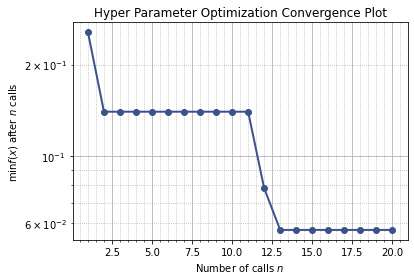

In [19]:
#@markdown Plot the HPO convergence
if use_optHPO.value: skopt_convergence( opt_params )
else: print( ">> Not running hyper parameter optimization..." )

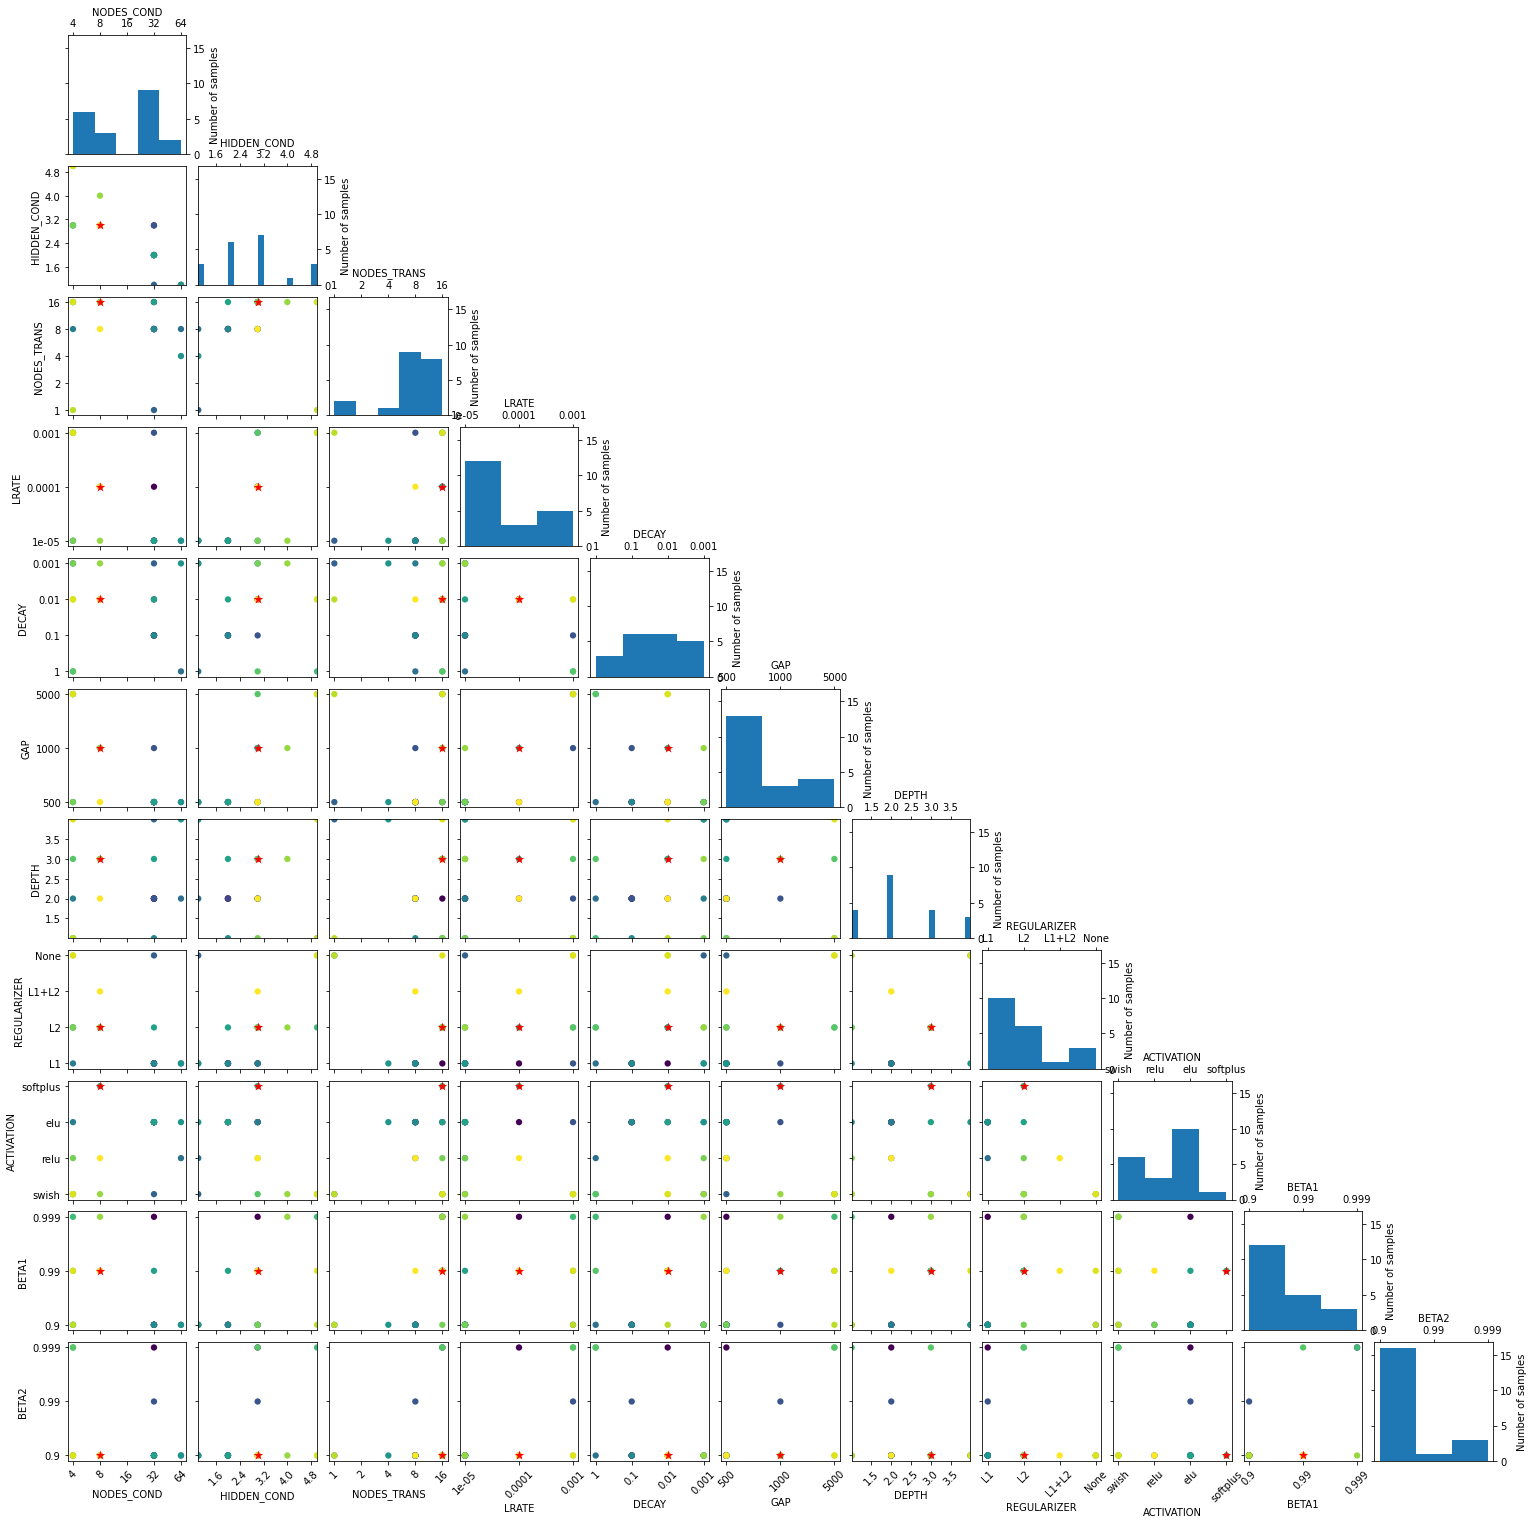

In [20]:
#@markdown Plot the HPO parameter evaluations
if use_optHPO.value: skopt_evaluations( opt_params, hyper )
else: print( ">> Not running hyper parameter optimization..." )

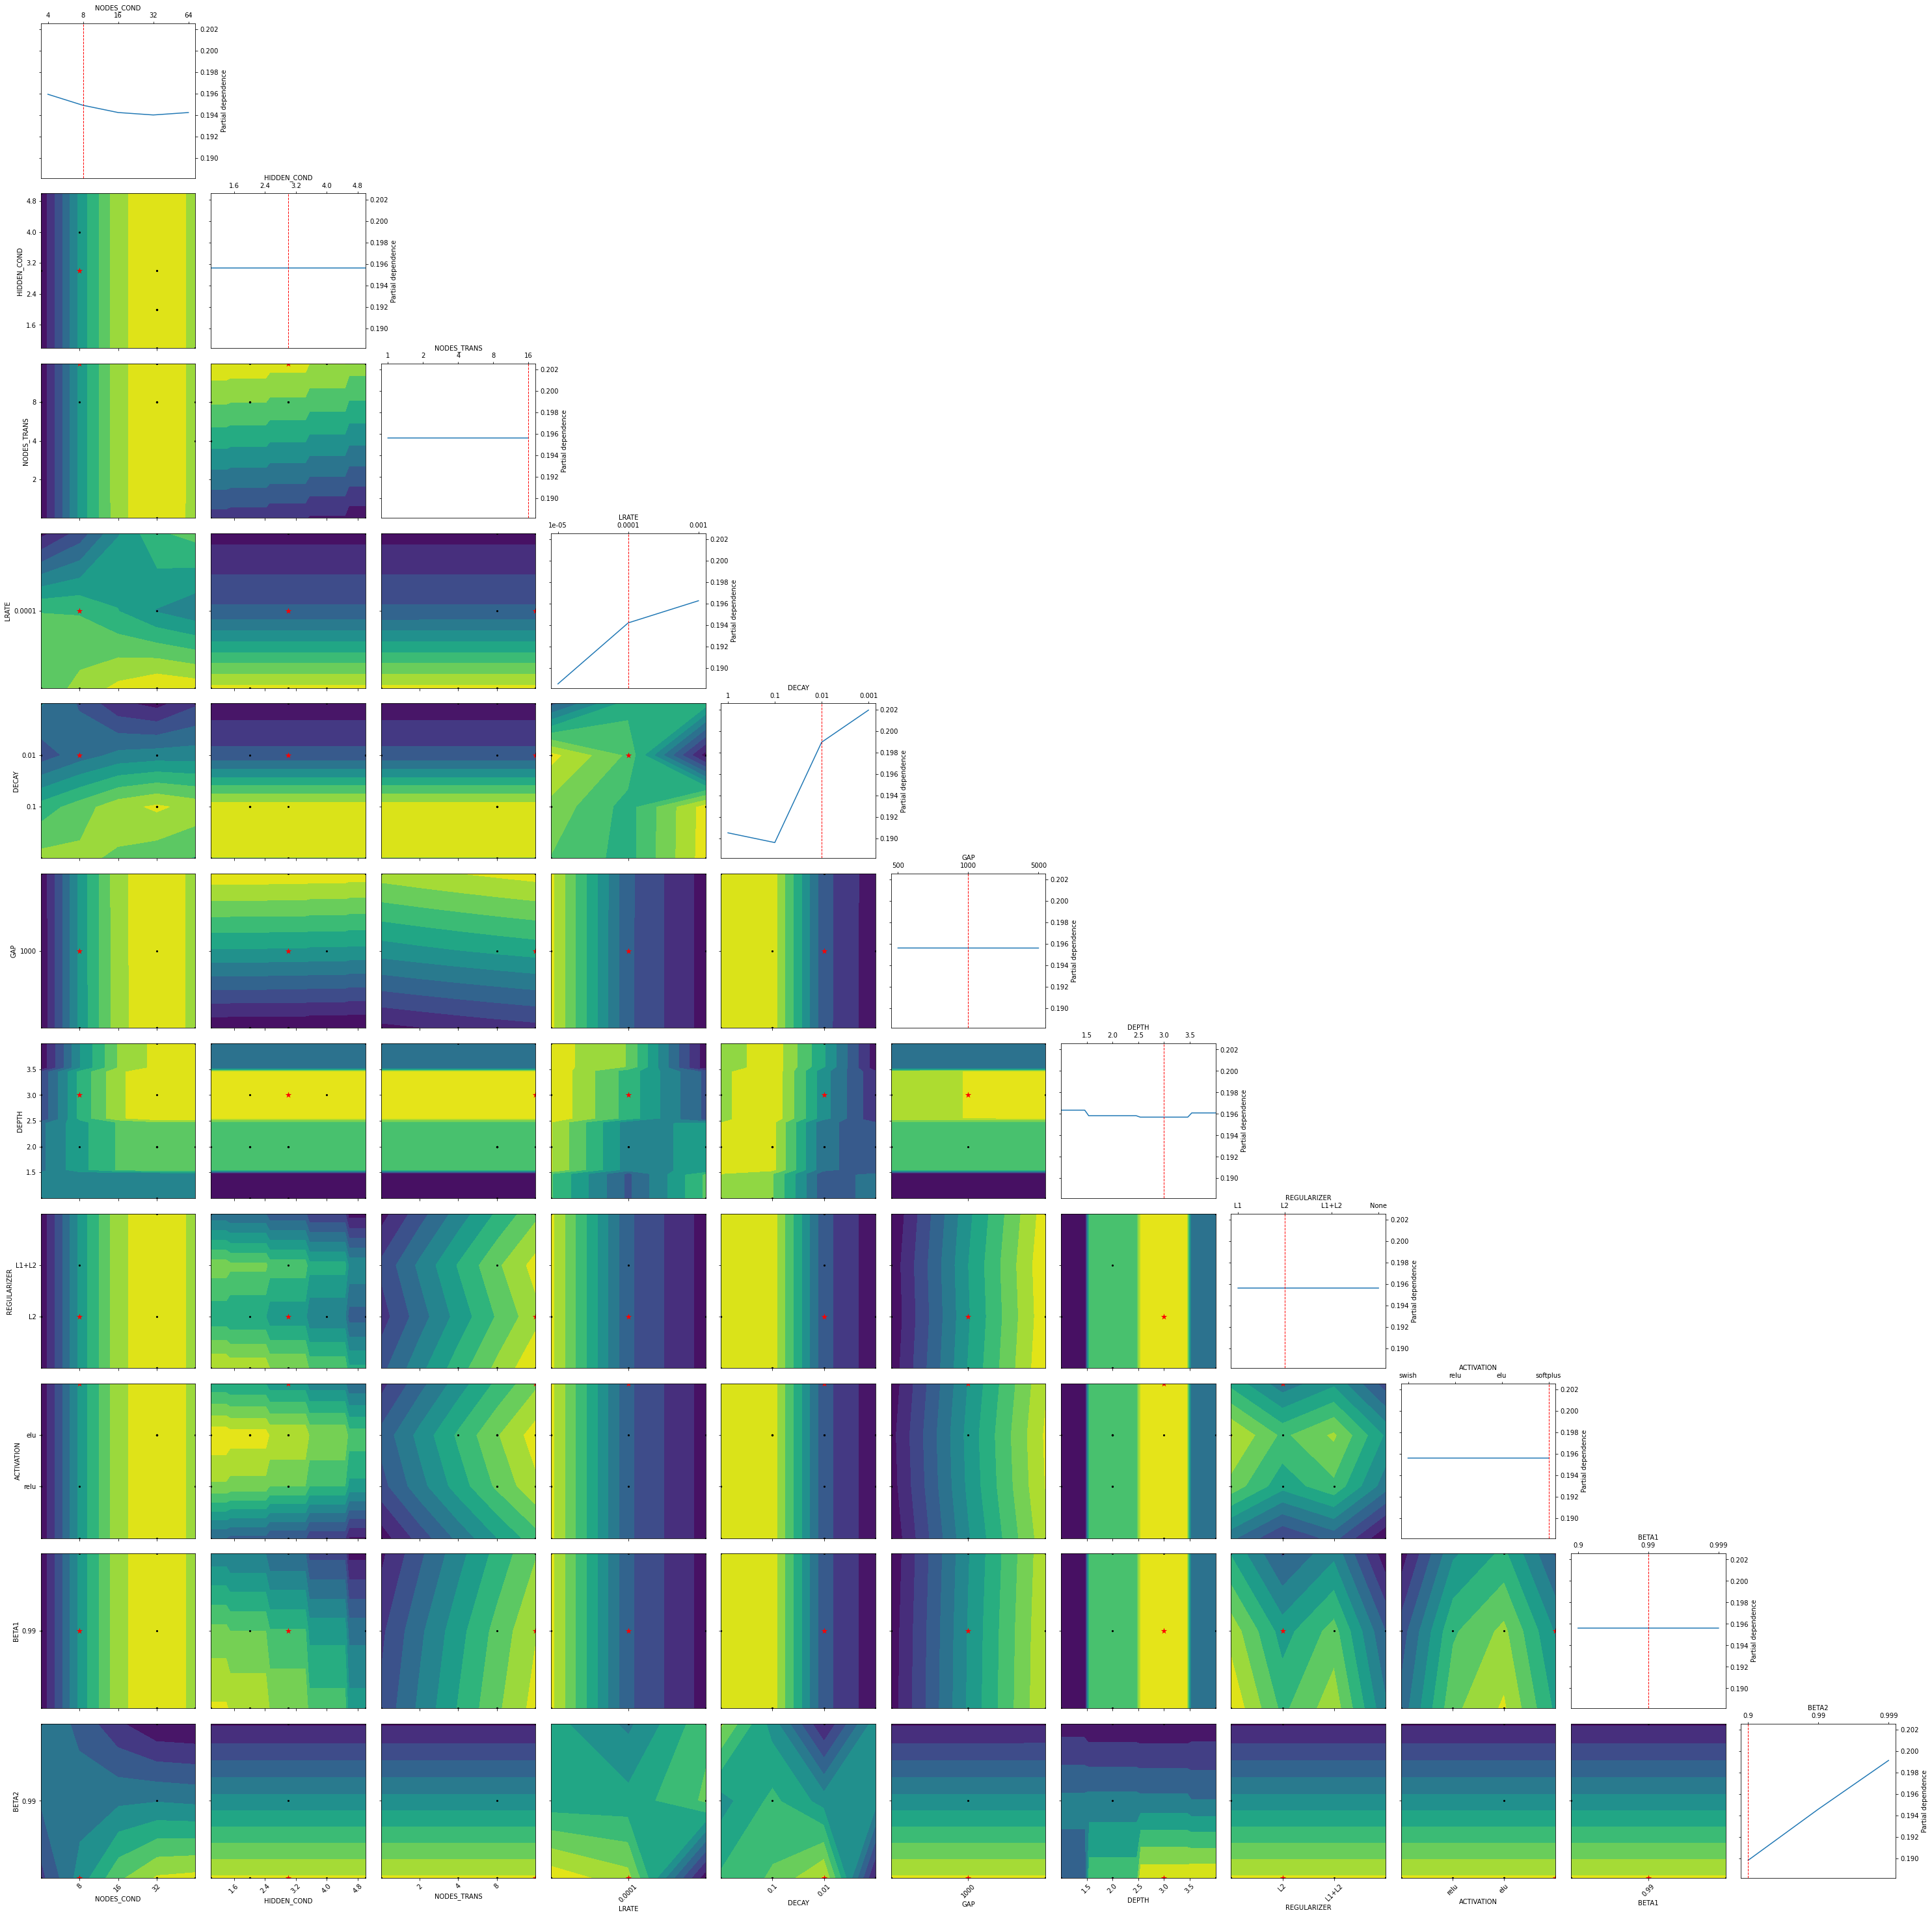

In [21]:
#@markdown Plot the HPO optimization objective
if use_optHPO.value: skopt_objective( opt_params, hyper )
else: print( ">> Not running hyper parameter optimization..." )

In [ ]:
#@title Run the `ABCDnn` setup and training
#@markdown Default option to run the training is to use the optimized hyper parameters, 
#@markdown select the parameter `use_optHPO` to be `False` and edit the parameters `dict`.
abcdnn = ABCDnn_training()
abcdnn.setup_events( 
    rSource = params[ "EVENTS" ][ "SOURCE" ], rTarget = params[ "EVENTS" ][ "TARGET" ], 
    selection = selection, variables = variables, regions = regions, 
    mc_weight = params[ "EVENTS" ][ "MCWEIGHT" ] 
    )


if use_optHPO.value:
  print( ">> Running optimized parameters..." )
  for i, param in enumerate( hyper[ "OPTIMIZE" ].keys() ):
    print( ">>   - {}: {}".format( param, opt_params.x[i] ) )
  abcdnn.setup_model( 
    nodes_cond = opt_params.x[0],
    hidden_cond = opt_params.x[1],
    nodes_trans = opt_params.x[2],
    lr = opt_params.x[3],
    decay = opt_params.x[4],
    gap = opt_params.x[5],
    depth = opt_params.x[6],
    regularizer = opt_params.x[7],
    activation = opt_params.x[8],
    beta1 = opt_params.x[9],
    beta2 = opt_params.x[10],
    minibatch = hyper[ "PARAMS" ][ "MINIBATCH" ], 
    savedir = params[ "MODEL" ][ "SAVEDIR" ], 
    seed = params[ "MODEL" ][ "SEED" ],
    verbose = params[ "MODEL" ][ "VERBOSE" ], 
    retrain = params[ "MODEL" ][ "RETRAIN" ]
    )
else:
  print( ">> Running custom parameters..." )
  abcdnn.setup_model( 
    nodes_cond = params[ "MODEL" ][ "NODES_COND" ], 
    hidden_cond = params[ "MODEL" ][ "HIDDEN_COND" ],
    nodes_trans = params[ "MODEL" ][ "NODES_TRANS" ],
    minibatch = params[ "MODEL" ][ "MINIBATCH" ], 
    lr = params[ "MODEL" ][ "LRATE" ], 
    gap = params[ "MODEL" ][ "GAP" ],
    depth = params[ "MODEL" ][ "DEPTH" ],
    activation = params[ "MODEL" ][ "ACTIVATION" ],
    regularizer = params[ "MODEL" ][ "REGULARIZER" ],
    decay = params[ "MODEL" ][ "DECAY" ],
    beta1 = params[ "MODEL" ][ "BETA1" ],
    beta2 = params[ "MODEL" ][ "BETA2" ],
    savedir = params[ "MODEL" ][ "SAVEDIR" ], 
    seed = params[ "MODEL" ][ "SEED" ], 
    verbose = params[ "MODEL" ][ "VERBOSE" ], 
    retrain = params[ "MODEL" ][ "RETRAIN" ]
  )

abcdnn.train( 
    steps = params[ "TRAIN" ][ "EPOCHS" ], 
    patience = params[ "TRAIN" ][ "PATIENCE" ],
    monitor = params[ "TRAIN" ][ "MONITOR" ], 
    display_loss = params[ "TRAIN" ][ "SHOWLOSS" ], 
    save_hp = params[ "TRAIN" ][ "SAVEHP" ] 
    )

abcdnn.evaluate_regions()

abcdnn.extended_ABCD()


>> Running optimized parameters...
>>   - NODES_COND: 8
>>   - HIDDEN_COND: 3
>>   - NODES_TRANS: 16
>>   - LRATE: 0.0001
>>   - DECAY: 0.01
>>   - GAP: 1000
>>   - DEPTH: 3
>>   - REGULARIZER: L2
>>   - ACTIVATION: softplus
>>   - BETA1: 0.99
>>   - BETA2: 0.9
Epoch / MMD (Train)    / MMD (Val)      / Min MMD (Val) 
0       1.650e+00        1.647e+00         1.647e+00     
1000    4.529e-02        1.762e-01         1.762e-01     
2000    1.503e-02        1.308e-01         8.132e-02     
3000    1.163e-02        1.351e-01         8.132e-02     
4000    1.094e-02        1.351e-01         8.132e-02     
5000    1.070e-02        1.387e-01         8.132e-02     
6000    1.045e-02        1.397e-01         8.132e-02     
>> Early stopping after 6082 epochs without improvement in loss (min loss = 8.13e-02)
>> Minimum loss (validation) of 8.132e-02 on epoch 1080
Region X (NJets_JetSubCalc == 5, NJetsCSV_MultiLepCalc == 2): MC = 65772, DATA = 10429 
Region Y (NJets_JetSubCalc == 5, NJetsCSV_Mul

In [ ]:
#@title Set plotting parameters __(edit me)__
params_plot = {
  "RATIO": [ 0.25, 2.0 ],   # y limits for the ratio plot
  "YSCALES": [ "log" ],  # histogram y axis scale
  "NBINS": 20,              # number of hist bins
  "ERRORBARS": True,        # include errorbars
  "NORMED": True,           # normalize histogram counts
  "SAVE": False,            # save plots as images
  "PLOT_KS": True           # include the KS p-value
}

In [ ]:
#@title Plot the Data versus Fake Data Histogram Comparison
abcdnn.plot_ratio(
      plot_data = True, plot_mc = False, plot_cr = True, plot_sr = True, 
      errorbars = params_plot[ "ERRORBARS" ], 
      normed = params_plot[ "NORMED" ], 
      ratio = params_plot[ "RATIO" ], 
      yscales = params_plot[ "YSCALES" ], 
      n_bins = params_plot[ "NBINS" ], 
      plot_ks = params_plot[ "PLOT_KS" ], 
      save = params_plot[ "SAVE" ]
    )

In [ ]:
#@title Plot the MC versus Fake Data Histogram Comparison
abcdnn.plot_ratio(
      plot_data = False, plot_mc = True, plot_cr = True, plot_sr = True, 
      errorbars = params_plot[ "ERRORBARS" ], 
      normed = params_plot[ "NORMED" ], 
      ratio = params_plot[ "RATIO" ], 
      yscales = params_plot[ "YSCALES" ], 
      n_bins = params_plot[ "NBINS" ], 
      plot_ks = params_plot[ "PLOT_KS" ], 
      save = params_plot[ "SAVE" ]
    )

In [ ]:
#@title Plot an overlayed histogram for the MC, Data and Predicted Data
abcdnn.plot_hist(
      plot_data = True, plot_mc = True, plot_cr = True, plot_sr = True,
      errorbars = True, normed = True, 
      yscales = [ "log" ], n_bins = 20, save = False 
    )

In [ ]:
#@title Plot the transfer function for each variable
abcdnn.plot_correlation( -1 )

In [ ]:
#@markdown Save the fake data to a ROOT file
abcdnn.save_root( tree_name = "abcdnn", file_name = "fake_data.root" )